# 建立电解系统动态模型

In [1]:
import os,gzip,pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import torch
import torch.nn as nn
import math
from torch.utils.data import DataLoader, TensorDataset

import torch.optim as optim
from transformers import LongformerConfig, LongformerModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keys import DataDir,Cols

## 读取原始运行数据

In [3]:
with gzip.open(
    r'C:\Users\Orz\OneDrive\Single_Stack_MLJ\data\processed\Test data Hyzenis\2025.04.08-8.30-2025.04.11-17.30-10s-1# gzip',
    'rb'
) as f:
    df_Hyzenis = pickle.load(f)

### 取适用于模型训练的部分数据

In [4]:
df_date_Hyzenis = df_Hyzenis.query(
    f"'2025-04-08 12:00:00'<{Cols.date_time}<'2025-04-11 14:00:00'"
)

### 原始数据展示

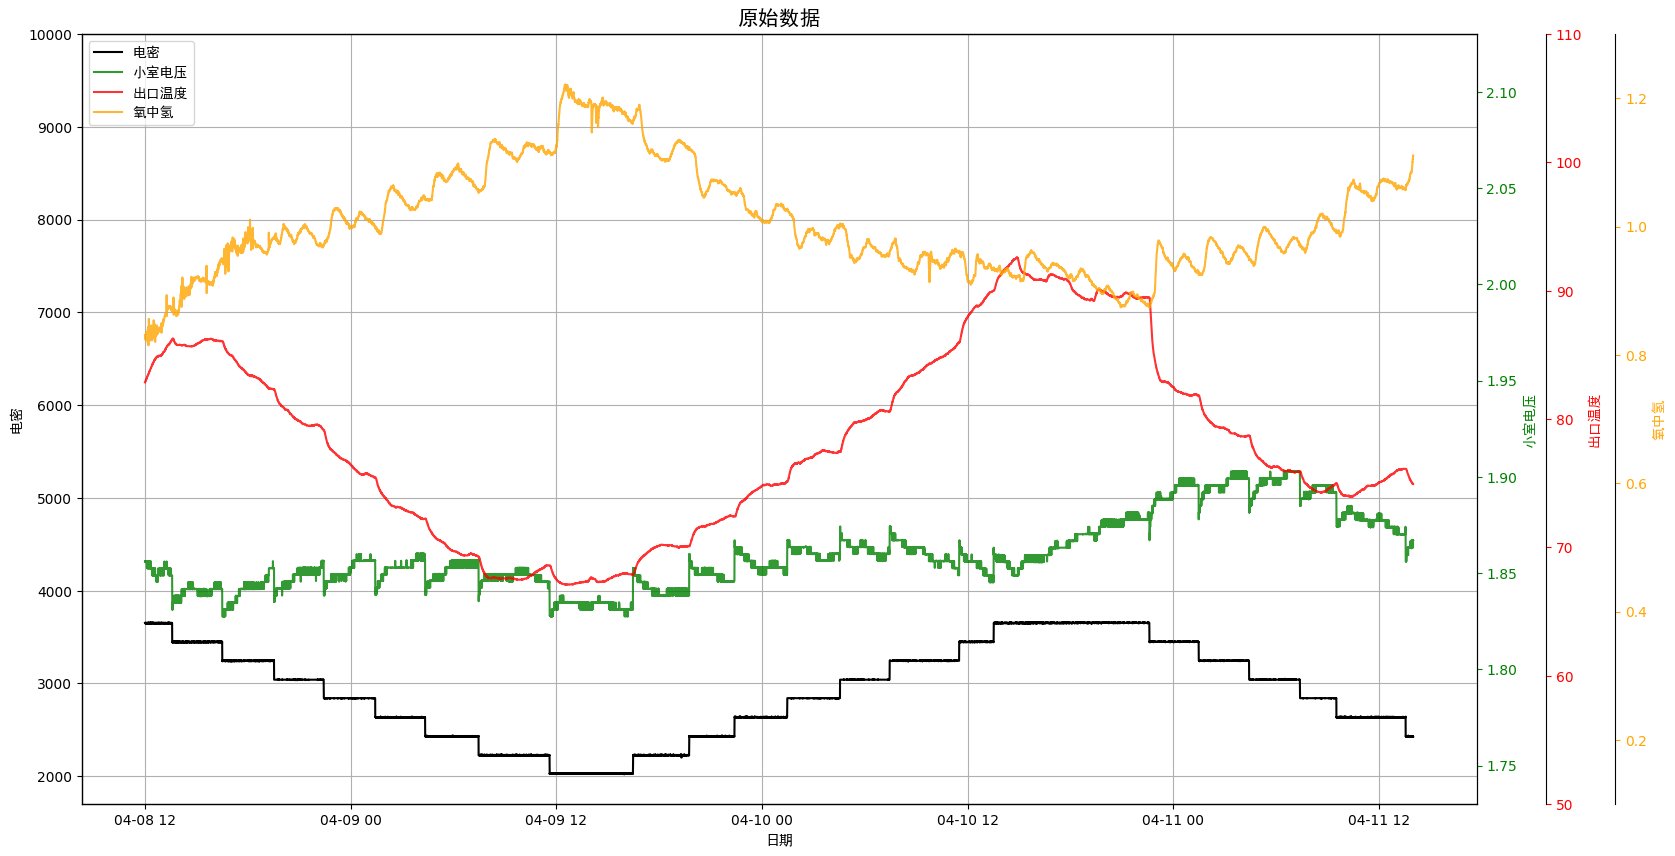

In [5]:
# 设置中文字体
font_path = 'C:/Windows/Fonts/simhei.ttf'  # 替换为你系统中支持中文的字体路径，这里以黑体为例
prop = fm.FontProperties(fname=font_path)

# 创建图表和子图
fig, ax1 = plt.subplots(figsize=(18, 10))
plt.title('原始数据', fontproperties=prop, fontsize = 15)
plt.grid(True)

# 绘制第一个因变量的曲线
ax1.plot(df_date_Hyzenis[Cols.date_time],df_date_Hyzenis[Cols.current_density], c = 'black', label = '电密')
ax1.set_xlabel('日期', fontproperties=prop)
ax1.set_ylabel('电密', color='black', fontproperties=prop)
ax1.set_ylim(1700, 10000)
ax1.tick_params('y', colors='black')

# 创建第二个y轴
ax2 = ax1.twinx()

# 绘制第二个因变量的曲线
ax2.plot(df_date_Hyzenis[Cols.date_time],df_date_Hyzenis[Cols.cell_voltage], alpha=0.8, c = 'green', label = '小室电压')
ax2.set_ylabel('小室电压', color='green', fontproperties=prop)
ax2.tick_params('y', colors='green')
ax2.set_ylim((1.73, 2.13))

# 创建第三个y轴
ax3 = ax1.twinx()

# 绘制第三个因变量的曲线
ax3.plot(df_date_Hyzenis[Cols.date_time],df_date_Hyzenis[Cols.temp_out], c = 'red', alpha = 0.8,label = '出口温度')
ax3.set_ylabel('出口温度', color='red', fontproperties=prop)
ax3.spines['right'].set_position(('outward', 50))
ax3.tick_params('y', colors='red')
ax3.set_ylim(50, 110)

# 创建第三个y轴
ax4 = ax1.twinx()

# 绘制第二个因变量的曲线
ax4.plot(df_date_Hyzenis[Cols.date_time],df_date_Hyzenis[Cols.HTO], c = 'orange', alpha = 0.8,label = '氧中氢')
ax4.set_ylabel('氧中氢', color='orange', fontproperties=prop)
ax4.spines['right'].set_position(('outward', 100))
ax4.tick_params('y', colors='orange')
ax4.set_ylim((0.1, 1.3))

# 添加图例
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()
ax1.legend(lines + lines2 + lines3 + lines4, labels + labels2 + labels3 + labels4, loc='upper left', prop=prop)

# 显示图表
plt.show()

## 以神经网络为框架建立电解槽动态热模型

In [6]:
# 指定保存模型的文件夹路径
save_folder = 'Model\\Dynamic_models'

# 检查文件夹是否存在，如果不存在则创建
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# 构建保存模型的完整路径
save_path = os.path.join(save_folder, 'Thermodynamic_model.pth')

In [7]:
# 检查GPU是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
# 1. 数据预处理
# 已有一个包含多个时间步的DataFrame（每一行代表一个时间步的所有参数）
# 加载并标准化数据
def preprocess_data(df, feature_cols, target_cols, future_steps=10):
    scaler = StandardScaler()
    # 特征数据
    X = df[feature_cols].values
    X_scaled = scaler.fit_transform(X)

    # 目标数据
    y = df[target_cols].values

    # 创建一个滑动窗口数据集，形成输入和输出
    X_data = []
    y_data = []

    for i in range(len(X_scaled) - future_steps):
        X_data.append(X_scaled[i:i+future_steps])
        y_data.append(y[i+future_steps])

    X_data = np.array(X_data)
    y_data = np.array(y_data)

    return X_data, y_data, scaler

# 自定义自适应稀疏自注意力（ASSA）模块
class ASSA(nn.Module):
    def __init__(self, hidden_size, num_heads, sparsity_threshold=0.1):
        super(ASSA, self).__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        self.sparsity_threshold = sparsity_threshold

        # 定义查询、键、值线性层
        self.q_proj = nn.Linear(hidden_size, hidden_size)
        self.k_proj = nn.Linear(hidden_size, hidden_size)
        self.v_proj = nn.Linear(hidden_size, hidden_size)

        # 输出投影层
        self.out_proj = nn.Linear(hidden_size, hidden_size)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        # 计算查询、键、值
        Q = self.q_proj(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.k_proj(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.v_proj(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        # 计算注意力分数
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)

        # 计算自适应稀疏掩码
        attn_probs = torch.softmax(attn_scores, dim=-1)
        mask = attn_probs > self.sparsity_threshold
        attn_probs = attn_probs * mask.float()

        # 归一化稀疏注意力分数
        attn_probs = attn_probs / (attn_probs.sum(dim=-1, keepdim=True) + 1e-8)

        # 计算上下文向量
        context = torch.matmul(attn_probs, V)
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.hidden_size)

        # 输出投影
        output = self.out_proj(context)
        return output

# 定义Transformer模型（使用ASSA进行稀疏注意力）
class SparseAttentionTransformer(nn.Module):
    def __init__(self, input_size, output_size, future_steps, hidden_size=256):
        super(SparseAttentionTransformer, self).__init__()

        # 新增线性层，将输入维度转换为hidden_size
        self.input_proj = nn.Linear(input_size, hidden_size)

        # 使用 ASSA 模块
        self.assa = ASSA(hidden_size=hidden_size, num_heads=8)

        # 后续全连接层
        self.fc1 = nn.Linear(hidden_size, 128)
        self.fc2 = nn.Linear(128, output_size)

    def forward(self, x):
        # x.shape = (batch_size, sequence_length, input_size)
        # 通过线性层将输入维度转换为hidden_size
        x = self.input_proj(x)

        # 使用 ASSA 进行编码
        transformer_out = self.assa(x)

        # 取最后一个时间步的输出
        last_hidden_state = transformer_out[:, -1, :]

        # 通过全连接层得到最终预测
        x = torch.relu(self.fc1(last_hidden_state))
        x = self.fc2(x)

        return x

# 3. 创建数据集和DataLoader
def create_dataloaders(df, feature_cols, target_cols, future_steps=10, batch_size=64):
    X_data, y_data, scaler = preprocess_data(df, feature_cols, target_cols, future_steps)

    # 转换为Tensor
    X_tensor = torch.tensor(X_data, dtype=torch.float32)
    y_tensor = torch.tensor(y_data, dtype=torch.float32)

    # 划分训练集和验证集
    train_size = int(0.8 * len(X_tensor))
    X_train, X_val = X_tensor[:train_size], X_tensor[train_size:]
    y_train, y_val = y_tensor[:train_size], y_tensor[train_size:]

    # 创建数据集和数据加载器
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, X_tensor, y_tensor, scaler

# 4. 模型训练
def train_model(model, train_loader, val_loader, device, epochs=1000, lr=1e-4, patience=50):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    # 早停策略参数
    best_val_loss = float('inf')
    counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            X_batch, y_batch = batch
            # 将数据移动到指定设备
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()

            # 前向传播
            y_pred = model(X_batch)

            # 计算损失
            loss = loss_fn(y_pred, y_batch)
            loss.backward()

            # 优化
            optimizer.step()

            total_loss += loss.item()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader)}')

        # 验证过程
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                X_batch, y_batch = batch
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        print(f'Epoch [{epoch + 1}/{epochs}], Val Loss: {val_loss}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), save_path)
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping!")
                break

    return model

#### 训练数据准备

In [10]:
# 训练数据准备
feature_cols = [Cols.current_density, Cols.lye_flow, Cols.temp_environment, Cols.lye_temp, Cols.temp_out, Cols.pressure]
target_cols = [Cols.temp_out]
train_loader, val_loader, X_tensor, y_tensor, scaler = create_dataloaders(df_date_Hyzenis, feature_cols, target_cols)

#### 模型准备

In [12]:
# 模型准备
model = SparseAttentionTransformer(input_size=len(feature_cols), output_size=len(target_cols), future_steps=10)
# 将模型移动到指定设备
model.to(device)

SparseAttentionTransformer(
  (input_proj): Linear(in_features=6, out_features=256, bias=True)
  (assa): ASSA(
    (q_proj): Linear(in_features=256, out_features=256, bias=True)
    (k_proj): Linear(in_features=256, out_features=256, bias=True)
    (v_proj): Linear(in_features=256, out_features=256, bias=True)
    (out_proj): Linear(in_features=256, out_features=256, bias=True)
  )
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [10]:
# 主程序
if __name__ == "__main__":
    trained_model = train_model(model, train_loader, val_loader, device)

Epoch [1/1000], Loss: 1675.7799231555011
Epoch [1/1000], Val Loss: 80.2614723614284
Epoch [2/1000], Loss: 7.079874957287991
Epoch [2/1000], Val Loss: 9.420858140502657
Epoch [3/1000], Loss: 0.8491562103276497
Epoch [3/1000], Val Loss: 7.222923379568827
Epoch [4/1000], Loss: 0.28002785853258483
Epoch [4/1000], Val Loss: 1.3756508419201487
Epoch [5/1000], Loss: 0.10596381189363138
Epoch [5/1000], Val Loss: 0.4705325932729812
Epoch [6/1000], Loss: 0.05085652380309126
Epoch [6/1000], Val Loss: 0.22788889227168901
Epoch [7/1000], Loss: 0.029342386306629883
Epoch [7/1000], Val Loss: 0.1312535586988642
Epoch [8/1000], Loss: 0.017453219157059094
Epoch [8/1000], Val Loss: 0.0871374852556203
Epoch [9/1000], Loss: 0.010800089203268737
Epoch [9/1000], Val Loss: 0.05426438197138764
Epoch [10/1000], Loss: 0.007240840719101038
Epoch [10/1000], Val Loss: 0.0394702274795799
Epoch [11/1000], Loss: 0.004903079096546715
Epoch [11/1000], Val Loss: 0.02325100935108605
Epoch [12/1000], Loss: 0.00380655548740

#### 模型评估

In [13]:
# 加载模型状态字典
if os.path.exists(save_path):
    model.load_state_dict(torch.load(save_path, map_location=device))
    model.eval()  # 将模型设置为评估模式
    print("Model loaded successfully.")
else:
    print(f"Model file {save_path} not found.")

Model loaded successfully.


In [14]:
# 进行模型预测
with torch.no_grad():
    X_test = X_tensor[0:100]
    y_test = y_tensor[0:100]
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    y_pred = model(X_test)

# 先将张量转移到 CPU 上
y_pred_cpu = y_pred.cpu()
y_test_cpu = y_test.cpu()

# 把转移到 CPU 上的张量转换为 numpy.ndarray
y_pred_numpy = y_pred_cpu.numpy()
y_test_numpy = y_test_cpu.numpy()

# 创建 DataFrame
y_pred_df = pd.DataFrame(y_pred_numpy, columns=target_cols)
y_test_df = pd.DataFrame(y_test_numpy, columns=target_cols)

### 生成训练结果图

Text(0, 0.5, 'temp_out_pred')

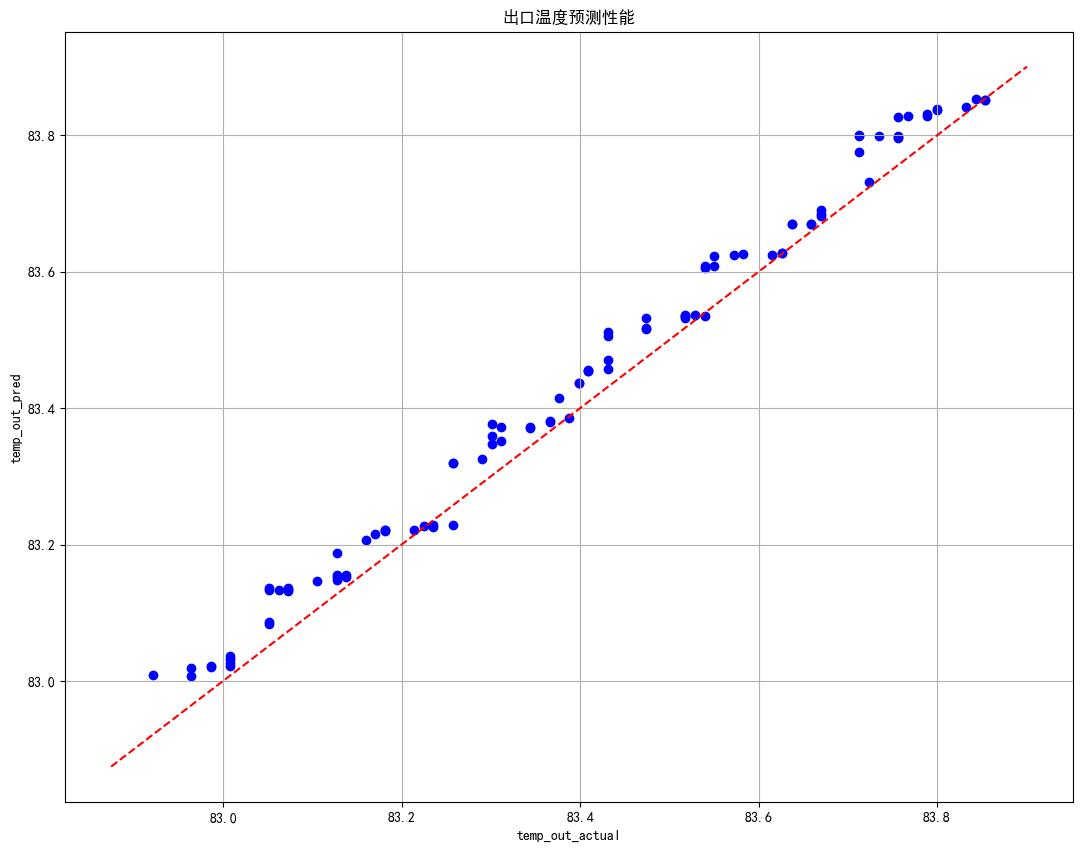

In [15]:
from utils import drawing_methods

scatterplotter = drawing_methods.ScatterPlotter((13, 10))
scatter_plot, ax = scatterplotter.draw_scatter_plot(y_test_df['temp_out'], y_pred_df['temp_out'], title = '出口温度预测性能')
# 获取坐标轴的范围
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
# 确定对角线的端点
diag_min = min(x_min, y_min)
diag_max = max(x_max, y_max)
# 绘制对角线
ax.plot([diag_min, diag_max], [diag_min, diag_max], color='red', linestyle='--')
ax.set_xlabel('temp_out_actual')
ax.set_ylabel('temp_out_pred')

### 滚动预测数据

In [16]:
# 创建模型实例
input_size = len(feature_cols)
output_size = len(target_cols)
model = SparseAttentionTransformer(input_size, output_size, future_steps=10)

# 加载模型状态字典
if os.path.exists(save_path):
    model.load_state_dict(torch.load(save_path, map_location=device))
    model.eval()  # 将模型设置为评估模式
    print("Model loaded successfully.")
else:
    print(f"Model file {save_path} not found.")

model.to(device)

predictions = []
future_steps = 10
pred_steps = 25000
statistics = df_date_Hyzenis[feature_cols]

for step in range(pred_steps):
    X_test_df = statistics[step : step + future_steps]
    X_test_np_scaler = np.array([scaler.transform(X_test_df.values)])
    X_tensor = torch.tensor(X_test_np_scaler, dtype=torch.float32).to(device)
    with torch.no_grad():
        y_pred = model(X_tensor)
    y_pred_numpy = y_pred.cpu().numpy()
    statistics.loc[step+future_steps, Cols.temp_out] = y_pred_numpy[0]
    predictions.append(y_pred_numpy[0])

Model loaded successfully.


C:\Users\Guhy\AppData\Local\Temp\ipykernel_22944\3976342087.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  statistics.loc[step+future_steps, Cols.temp_out] = y_pred_numpy[0]


##### 展示结果图

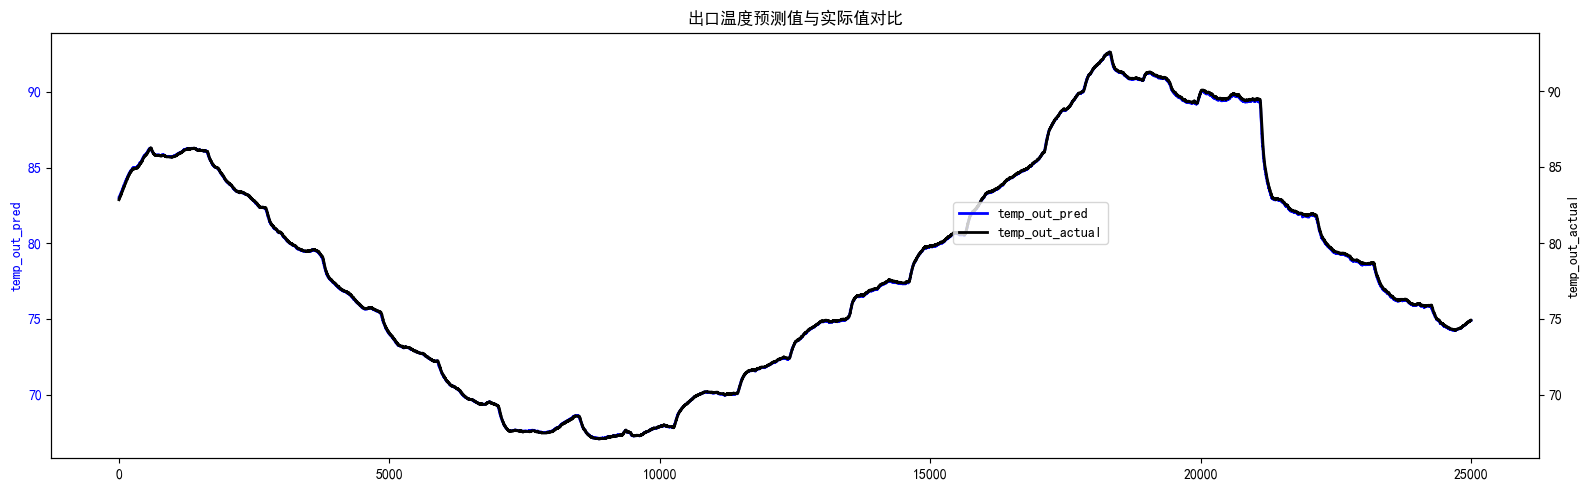

In [17]:
from utils.drawing_methods import LinePlotter
lineplotter = LinePlotter()

# 创建 DataFrame
y_pred_df_pred = pd.DataFrame(predictions, columns=target_cols)

temp_out_pred = y_pred_df_pred[Cols.temp_out]
temp_out_pred.name = 'temp_out_pred'
# 将 Series 转换为 DataFrame
temp_out_pred_df = temp_out_pred.to_frame()

temp_out_actual = df_date_Hyzenis[Cols.temp_out].iloc[:pred_steps].values
temp_out_actual_df = pd.Series(temp_out_actual, name = 'temp_out_actual')


temp_out_pred_df['temp_out_actual'] = temp_out_actual

colors = {
    'temp_out_pred' : 'blue',
    'temp_out_actual' : 'black'
}

fig, ax = lineplotter.multiple_variable_plot(temp_out_pred_df.index, temp_out_pred_df, color=colors, title = '出口温度预测值与实际值对比', legend_bbox_to_anchor=(0.7, 0.6))

## 以LSTM为框架训练换热器模型

In [55]:
df_date_Hyzenis_process = df_date_Hyzenis.copy()

In [6]:
# 训练数据准备
feature_cols = [Cols.lye_flow, Cols.temp_environment, Cols.lye_temp, Cols.temp_out, '冷水调节阀1反馈']
target_cols = [Cols.lye_temp]

In [29]:
import torch.optim as optim
from torch.utils.data import Dataset
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [56]:
# ================ 1. 数据处理 ================
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def create_sequences(df, feature_cols, target_col, seq_length):
    """创建时序训练样本"""
    X, y = [], []
    for i in range(len(df) - seq_length):
        X.append(df[feature_cols].iloc[i:i+seq_length].values)
        y.append(df[target_col].iloc[i+seq_length])
    return np.array(X), np.array(y)

# 创建时序样本（使用前20个时间步预测下一个）
seq_length = 10
X, y = create_sequences(df_date_Hyzenis_process, feature_cols, target_cols[0], seq_length)

# 划分训练集和测试集（80%训练，20%测试）
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 创建数据加载器
batch_size = 32
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [65]:
print(y_train)

[64.80034637 64.822052   64.822052   ... 58.83246613 58.83246613
 58.83246613]


In [66]:
# ================ 2. 定义LSTM模型 ================
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM层（batch_first=True使输入格式为[batch, seq_len, features]）
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )
        
        # 全连接层（预测碱液温度）
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, output_size)
        )
        
    def forward(self, x):
        # 初始化隐藏状态和细胞状态（全0张量）
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # LSTM前向传播，out形状为[batch, seq_len, hidden_size]
        out, _ = self.lstm(x, (h0, c0))
        
        # 只取序列最后一个时间步的输出进行预测
        out = self.fc(out[:, -1, :])
        return out

# 初始化模型并移至设备（CPU/GPU）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(
    input_size=len(feature_cols),     # 特征数：5个输入特征
    hidden_size=64,                   # LSTM隐藏层维度
    num_layers=2,                     # LSTM层数
    output_size=1                     # 输出维度：预测碱液温度
).to(device)

In [67]:
# ================ 3. 训练模型 ================
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # 前向传播
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
    
    return total_loss / len(test_loader)

# 训练循环
num_epochs = 50
best_loss = float('inf')
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = evaluate(model, test_loader, criterion, device)
    
    # 学习率调整
    scheduler.step(val_loss)
    
    # 保存最佳模型
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_lstm_model.pth')
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

Epoch 1/50, Train Loss: 325.639193, Val Loss: 6.995087
Epoch 2/50, Train Loss: 39.887522, Val Loss: 72.238302
Epoch 3/50, Train Loss: 27.795655, Val Loss: 76.438801
Epoch 4/50, Train Loss: 27.540483, Val Loss: 60.275322
Epoch 5/50, Train Loss: 27.314817, Val Loss: 76.055912
Epoch 6/50, Train Loss: 26.801258, Val Loss: 51.095967
Epoch 7/50, Train Loss: 27.139991, Val Loss: 50.307864
Epoch 8/50, Train Loss: 26.660960, Val Loss: 54.288163
Epoch 9/50, Train Loss: 26.484018, Val Loss: 48.415507
Epoch 10/50, Train Loss: 26.693215, Val Loss: 41.212633
Epoch 11/50, Train Loss: 25.928593, Val Loss: 55.438837
Epoch 12/50, Train Loss: 26.510644, Val Loss: 38.666012
Epoch 13/50, Train Loss: 26.521651, Val Loss: 45.593717
Epoch 14/50, Train Loss: 25.402046, Val Loss: 44.339075
Epoch 15/50, Train Loss: 25.508250, Val Loss: 50.869305
Epoch 16/50, Train Loss: 25.673324, Val Loss: 46.594549
Epoch 17/50, Train Loss: 25.408298, Val Loss: 47.691533
Epoch 18/50, Train Loss: 25.516240, Val Loss: 47.797210
E

In [59]:
# ================ 4. 模型评估与预测 ================
# 加载最佳模型
model.load_state_dict(torch.load('best_lye_temp_lstm.pth'))
model.eval()

# 预测测试集
y_pred = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch).squeeze()
        y_pred.extend(outputs.cpu().numpy())

# 计算评估指标
mae = np.mean(np.abs(y_test - y_pred))
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
print(f'测试集 MAE: {mae:.6f}, RMSE: {rmse:.6f}')

测试集 MAE: 55.190480, RMSE: 55.212457


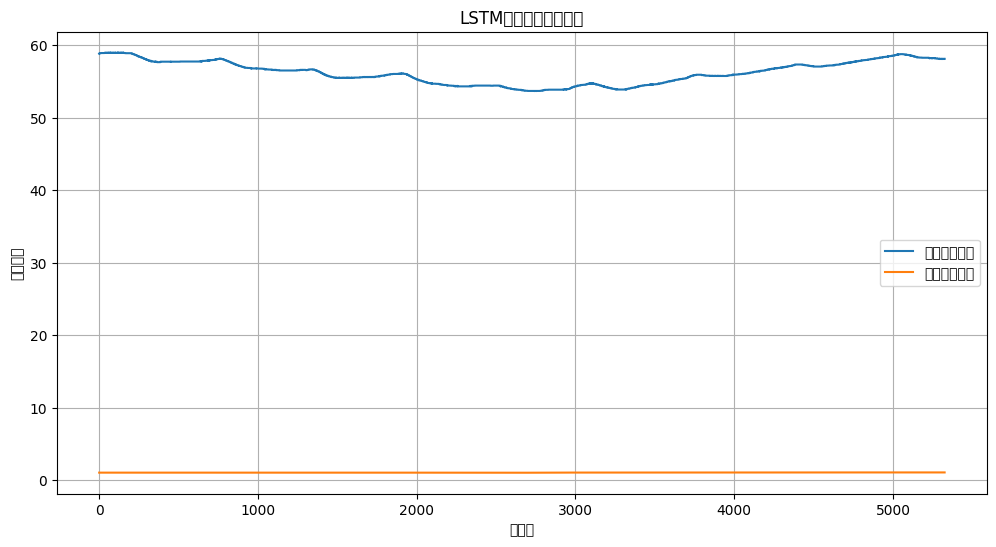

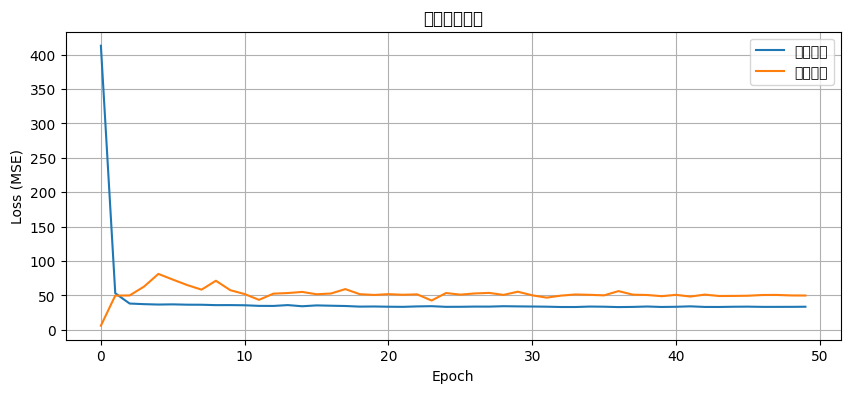

In [63]:
# ================ 5. 可视化结果 ================
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='实际碱液温度')
plt.plot(y_pred, label='预测碱液温度')
plt.title('LSTM模型预测碱液温度')
plt.xlabel('时间步')
plt.ylabel('碱液温度')
plt.legend()
plt.grid(True)
plt.show()

# 绘制训练过程损失曲线
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='训练损失')
plt.plot(val_losses, label='验证损失')
plt.title('模型训练过程')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()